In [1]:
import keras.backend as K

import tensorflow as tf

from keras.activations import relu
from keras.initializers import RandomNormal
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, Concatenate, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import regularizers

import matplotlib.pyplot as plt

import sys
import os

import numpy as np
import PIL

In [2]:
img_rows = 256
img_cols = 256
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100

lr_d = 2e-5
lr_g = 5e-6
optimizer_d = Adam(lr = lr_d, beta_1 = 0.0, beta_2 = 0.9)
optimizer_g = Adam(lr = lr_g, beta_1 = 0.0, beta_2 = 0.9)

In [3]:
def critic():
    in_img = Input(shape = img_shape)
    in_label = Input(shape = (1,))
    ll = Dense(256*256)(in_label)
    ll = Reshape(img_shape)(ll)
    merge = Concatenate()([in_img, ll])
    
    fe = Conv2D(8, kernel_size=5, strides=2, padding="same")(merge)
    fe = LeakyReLU(alpha = 0.2)(fe)
    fe = Conv2D(16, kernel_size=5, strides=2, padding="same")(fe)
    fe = LeakyReLU(alpha = 0.2)(fe)
    fe = Conv2D(32, kernel_size=5, strides=2, padding="same")(fe)
    fe = LeakyReLU(alpha = 0.2)(fe)
    fe = Conv2D(64, kernel_size=5, strides=2, padding="same")(fe)
    fe = LeakyReLU(alpha = 0.2)(fe)
    fe = Conv2D(128, kernel_size=5, strides=2, padding="same")(fe)
    fe = LeakyReLU(alpha = 0.2)(fe)
    fe = Conv2D(256, kernel_size=5, strides=2, padding="same")(fe)
    fe = LeakyReLU(alpha = 0.2)(fe)
    fe = Conv2D(512, kernel_size=5, strides=2, padding="same")(fe)
    fe = LeakyReLU(alpha = 0.2)(fe)
    fe = Flatten()(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha = 0.2)(fe)
    
    out_layer = Dense(1, kernel_regularizer=regularizers.l2(0.1))(fe)
    
    return Model([in_img, in_label], out_layer)

In [4]:
def generator():
    noise = Input(shape = (latent_dim,))
    in_label = Input(shape = (1,))
    
    gg = Dense(128*8*8)(noise)
    gg = Reshape((8,8,128))(gg)
    ll = Dense(8*8*16)(in_label)
    ll = Reshape((8,8,16))(ll)
    merge = Concatenate()([gg,ll])
    
    gen = Conv2DTranspose(128, kernel_size = 5, strides = 2, padding = 'same')(merge)
    gen = LeakyReLU(alpha = 0.2)(gen)
    gen = Conv2DTranspose(64, kernel_size = 5, strides = 2, padding = 'same')(gen)
    gen = LeakyReLU(alpha = 0.2)(gen)
    gen = Conv2DTranspose(32, kernel_size = 5, strides = 2, padding = 'same')(gen)
    gen = LeakyReLU(alpha = 0.2)(gen)
    gen = Conv2DTranspose(16, kernel_size = 5, strides = 2, padding = 'same')(gen)
    gen = LeakyReLU(alpha = 0.2)(gen)
    gen = Conv2DTranspose(8, kernel_size = 5, strides = 2, padding = 'same')(gen)
    gen = LeakyReLU(alpha = 0.2)(gen)

    
    gen = Conv2D(8, kernel_size =3, activation = 'tanh', padding = 'same')(gen)
    out_layer = Conv2D(1, kernel_size = 3, activation = 'tanh', padding = 'same')(gen)
    
    
    return Model([noise,in_label], out_layer)

In [5]:
net_d = critic()
net_d.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 65536)        131072      input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 256, 256, 1)  0           dense[0][0]                      
______________________________________________________________________________________________

In [6]:
net_g = generator()
net_g.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 8192)         827392      input_3[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1024)         2048        input_4[0][0]                    
____________________________________________________________________________________________

In [7]:
def d_training(real_img, noise, label):
    with tf.GradientTape() as tape_d:
        fake_img = net_g([noise, label])
        loss_real = tf.reduce_mean(net_d([real_img, label]))
        loss_fake = tf.reduce_mean(net_d([fake_img, label]))
        
        with tf.GradientTape() as tape_penalty:
            epsilon = tf.random.uniform([batch_size], 0, 1)
            epsilon = tf.reshape(epsilon, (-1,1,1,1))
            interpolated_img = epsilon*real_img + (1-epsilon)*fake_img
            tape_penalty.watch(interpolated_img)
            interpolated_out = net_d([interpolated_img, label])
            grad_interpolated = tape_penalty.gradient(interpolated_out, interpolated_img)
            grad_norm = K.sqrt(K.sum(K.square(grad_interpolated), axis = [1,2,3]))
            grad_penalty = K.mean(K.square(grad_norm-1))
        
        loss = loss_fake - loss_real + 1*grad_penalty
        grad_d = tape_d.gradient(loss, net_d.trainable_weights)
        optimizer_d.apply_gradients(zip(grad_d, net_d.trainable_weights))
    
    return (loss_real, loss_fake, loss)

In [8]:
def g_training(noise, label):
    with tf.GradientTape() as tape_g:
        gen_img = net_g([noise, label])
        loss = -tf.reduce_mean(net_d([gen_img, label]))
        grad_g = tape_g.gradient(loss, net_g.trainable_weights)
        optimizer_g.apply_gradients(zip(grad_g, net_g.trainable_weights))
    return loss

In [9]:
def load_samples():
    dirct_name = 'idealized micrographs/'
    
    train_set = []
    for i in range(1,12):
        subset_name = dirct_name + 'pdf' + str(i)
        image_names = os.listdir(subset_name)
        if '.ipynb_checkpoints' in image_names:
            image_names.remove('.ipynb_checkpoints')
        for item in image_names:
            img = PIL.Image.open(subset_name+'/'+item)
            arr = np.asarray(img)   
            train_set.append(arr)
                
            
    train_X = np.reshape(train_set, (3000*11,256,256,1))
    
    labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]
    
    train_Y_l = []
    for i in range(11):
        train_Y_l.append(labels[i]*np.ones((3000,1)))
        

    train_Y = np.reshape(train_Y_l, (-1,1))
        
    return (train_X,train_Y)

In [10]:
(train_X,train_Y) = load_samples()
print(train_X.shape)
print(train_Y.shape)

(33000, 256, 256, 1)
(33000, 1)


In [11]:
train_X_n = (train_X.astype(np.float32) - 0.5) / 0.5

In [12]:
#train and test set split
test_X = train_X_n[5*3000:6*3000]
train_X_split = np.concatenate((train_X_n[0:5*3000], train_X_n[6*3000:]))
test_Y = train_Y[5*3000:6*3000]
train_Y_split = np.concatenate((train_Y[0:5*3000], train_Y[6*3000:]))

print(test_X.shape)
print(train_X_split.shape)

(3000, 256, 256, 1)
(30000, 256, 256, 1)


[1.]
[ True]
[1.]


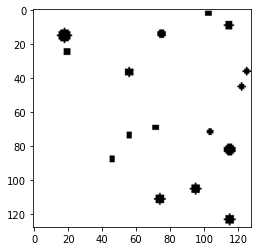

In [18]:
plt.imshow(train_X_split[1],'gray')
print(train_X_split[1][20][18])
print(train_X[1][20][18])
print(train_X[1][20][18].astype(np.float32))

In [13]:
epochs = 400
num_sample = train_X_split.shape[0]
batch_size = 128
num_minibatch = num_sample // batch_size + 1
g_loss_history = []

    
for i in range(epochs):
    shuffled_idx = np.random.randint(0, train_X_split.shape[0],train_X_split.shape[0])
    for j in range(num_minibatch):
        minibatch_idx = shuffled_idx[j*batch_size:min((j+1)*batch_size, num_sample)]
        imgs = train_X_split[idx]
        labels = train_Y_split[idx]
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        err_d_real, err_d_fake, loss_total = d_training(imgs, noise, labels)
        err_g = g_training(noise, labels)

    
    if i%10 == 0:
        print ("%d [D loss : %f] [G loss: %f]" % (i, loss_total, err_g))
        g_loss_history.append(err_g)
        r = 2
        c = 2
        noise_g = np.random.normal(0, 1, (1, 100))
        for j in range(2):
            noise_c = np.copy(noise_g)
            noise_g = np.concatenate((noise_g, noise_c), axis = 0)
        sampled_labels = np.asarray(([0.1,0.4,0.8,1.1]))
        fake_imgs = net_g.predict([noise_g, sampled_labels])
        fake_imgs = fake_imgs * 0.5 + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for k in range(r):
            for l in range(c):
                axs[j,k].imshow(fake_imgs[cnt,:,:,0], cmap='gray')
                axs[j,k].axis('off')
                cnt += 1
        fig.savefig("saved_images/%d.png" % i)
        plt.close()
        
net_g.save('saved_models/idealized_generator_0527')
net_d.save('saved_models/idealized_discriminator_0527')

0 [D loss : 0.993965] [G loss: 0.000080]
200 [D loss : -9439.722656] [G loss: -55.513046]
400 [D loss : -12138.750000] [G loss: -492.372986]
600 [D loss : -10977.472656] [G loss: -2536.614746]
800 [D loss : -7320.912109] [G loss: -4960.238770]
1000 [D loss : -4167.177734] [G loss: -3955.082275]
1200 [D loss : -2941.420410] [G loss: 1740.855713]
1400 [D loss : -3777.000000] [G loss: 1447.374023]
1600 [D loss : -3726.622314] [G loss: 1935.254028]
1800 [D loss : -3544.000244] [G loss: 464.967072]
2000 [D loss : -2949.681885] [G loss: -1547.033936]
2200 [D loss : -2165.202393] [G loss: -2741.701904]
2400 [D loss : -1763.595947] [G loss: -3240.333984]
2600 [D loss : -2424.676025] [G loss: -2606.427002]
2800 [D loss : -2569.311523] [G loss: -1752.738037]
3000 [D loss : -2688.349121] [G loss: -1119.095459]
3200 [D loss : -3251.802246] [G loss: -940.910400]
3400 [D loss : -2967.203125] [G loss: -555.157837]
3600 [D loss : -2763.044434] [G loss: -608.205383]
3800 [D loss : -2582.634521] [G loss

KeyboardInterrupt: 

In [20]:
los_hist = np.asarray(g_loss_history)
los_hist.shape

(0,)